# Time Series Forecasting with BigFrames

This notebook provides a comprehensive walkthrough of time series forecasting using the BigFrames library. We will explore two powerful models, TimesFM and ARIMAPlus, to predict bikeshare trip demand based on historical data from San Francisco. The process covers data loading, preprocessing, model training, and visualization of the results.

In [1]:
import bigframes.pandas as bpd
from bigframes.ml import forecasting
bpd.options.display.repr_mode = "anywidget"

### 1. Data Loading and Preprocessing

The first step is to load the San Francisco bikeshare dataset from BigQuery. We then preprocess the data by filtering for trips made by 'Subscriber' type users from 2018 onwards. This ensures we are working with a relevant and consistent subset of the data. Finally, we aggregate the trip data by the hour to create a time series of trip counts.

In [2]:
df = bpd.read_gbq("bigquery-public-data.san_francisco_bikeshare.bikeshare_trips")
df = df[df["start_date"] >= "2018-01-01"]
df = df[df["subscriber_type"] == "Subscriber"]
df["trip_hour"] = df["start_date"].dt.floor("h")
df_grouped = df[["trip_hour", "trip_id"]].groupby("trip_hour").count().reset_index()
df_grouped = df_grouped.rename(columns={"trip_id": "num_trips"})

### 2. Forecasting with TimesFM

In this section, we use the TimesFM (Time Series Foundation Model) to forecast future bikeshare demand. TimesFM is a powerful model designed for a wide range of time series forecasting tasks. We will use it to predict the number of trips for the last week of our dataset.

In [3]:
result = df_grouped.head(2842-168).ai.forecast(
    timestamp_column="trip_hour",
    data_column="num_trips",
    horizon=168
)
result

/usr/local/google/home/shuowei/src/python-bigquery-dataframes/bigframes/dataframe.py:5264: FutureWarning: The 'ai' property will be removed. Please use 'bigframes.bigquery.ai'
instead.
  warnings.warn(msg, category=FutureWarning)


Computation deferred. Computation will process 7.1 kB

### 3. Forecasting with ARIMAPlus

Next, we will use the ARIMAPlus model, which is a BigQuery ML model available through BigFrames. ARIMAPlus is an advanced forecasting model that can capture complex time series patterns. We will train it on the same historical data and use it to forecast the same period as the TimesFM model.

In [4]:
model = forecasting.ARIMAPlus(
    auto_arima_max_order=5,  # Reduce runtime for large datasets
    data_frequency="hourly",
    horizon=168
)
X = df_grouped.head(2842-168)[["trip_hour"]]
y = df_grouped.head(2842-168)[["num_trips"]]
model.fit(
    X, y
)
predictions = model.predict(horizon=168, confidence_level=0.95)
predictions

Computation deferred. Computation will process 10.8 kB

### 4. Compare and Visualize Forecasts

Now we will visualize the forecasts from both TimesFM and ARIMAPlus against the actual historical data. This allows for a direct comparison of the two models' performance.

<Axes: title={'center': 'Trip Forecasts Comparison'}, xlabel='trip_hour'>

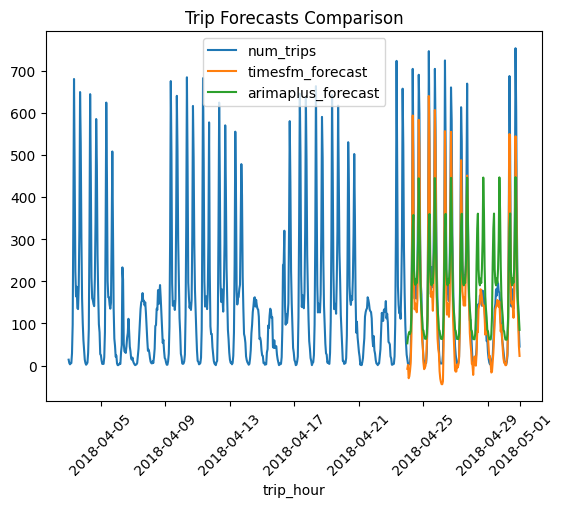

In [5]:
timesfm_result = result.sort_values("forecast_timestamp")[["forecast_timestamp", "forecast_value"]]
timesfm_result = timesfm_result.rename(columns={
    "forecast_timestamp": "trip_hour",
    "forecast_value": "timesfm_forecast"
})
arimaplus_result = predictions.sort_values("forecast_timestamp")[["forecast_timestamp", "forecast_value"]]
arimaplus_result = arimaplus_result.rename(columns={
    "forecast_timestamp": "trip_hour",
    "forecast_value": "arimaplus_forecast"
})
df_all = df_grouped.merge(timesfm_result, on="trip_hour", how="left")
df_all = df_all.merge(arimaplus_result, on="trip_hour", how="left")
df_all.tail(672).plot.line(
    x="trip_hour",
    y=["num_trips", "timesfm_forecast", "arimaplus_forecast"],
    rot=45,
    title="Trip Forecasts Comparison"
)

### 5. Multiple Time Series Forecasting

This section demonstrates a more advanced capability of ARIMAPlus: forecasting multiple time series simultaneously. This is useful when you have several independent series that you want to model together, such as trip counts from different bikeshare stations. The `id_col` parameter is key here, as it is used to differentiate between the individual time series.

In [6]:
df_multi = bpd.read_gbq("bigquery-public-data.san_francisco_bikeshare.bikeshare_trips")
df_multi = df_multi[df_multi["start_station_name"].str.contains("Market|Powell|Embarcadero")]
features = bpd.DataFrame({
    "start_station_name": df_multi["start_station_name"],
    "num_trips": df_multi["start_date"],
    "date": df_multi["start_date"].dt.date,
})
num_trips = features.groupby(
    ["start_station_name", "date"], as_index=False
).count()
model.fit(
    num_trips[["date"]],
    num_trips[["num_trips"]],
    id_col=num_trips[["start_station_name"]]
)
predictions_multi = model.predict()
predictions_multi

/usr/local/google/home/shuowei/src/python-bigquery-dataframes/bigframes/core/log_adapter.py:182: TimeTravelCacheWarning: Reading cached table from 2025-12-12 03:47:11.144938+00:00 to avoid
incompatibilies with previous reads of this table. To read the latest
version, set `use_cache=False` or close the current session with
Session.close() or bigframes.pandas.close_session().
  return method(*args, **kwargs)
/usr/local/google/home/shuowei/src/python-bigquery-dataframes/bigframes/ml/forecasting.py:238: UserWarning: Converting Date column 'date' to datetime for hourly frequency. This is required because BigQuery ML doesn't support Date type with hourly frequency.
  warnings.warn(


Computation deferred. Computation will process 11.5 kB